In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import seaborn as sns
from itertools import product
from sklearn.preprocessing import MinMaxScaler
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

# Specifications

In [2]:
space_thres = 3 # Spatial threshold
time_thres = 5  # Temporal threshold
num_thres = 7 # Minimum number of points to form a cluster
return_per = 'returnPeriod_MSWEP_1d' # Return period to plot

disaster_name = 'KATRINA'
disaster_name2 = 'IKE'

In [3]:
var = f'st_cluster_{space_thres}_{time_thres}_{num_thres}'
claim_num = -1
claim_num2 = -1

if disaster_name == 'KATRINA':
    claim_num = 4
elif disaster_name == 'HARVEY':
    claim_num = 243
elif disaster_name == 'SANDY':
    claim_num = 103
elif disaster_name == 'IKE':
    claim_num = 7
elif disaster_name == 'IVAN':
    claim_num = 6
else:
    print("error, no disaster specified for claims")

if disaster_name2 == 'KATRINA':
    claim_num2 = 4
elif disaster_name2 == 'HARVEY':
    claim_num2 = 243
elif disaster_name2 == 'SANDY':
    claim_num2 = 103
elif disaster_name2 == 'IKE':
    claim_num2 = 7
elif disaster_name2 == 'IVAN':
    claim_num2 = 6
else:
    print("error, no second disaster specified for claims")

# Load

In [4]:
# Load the county shapefile
county_shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(county_shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)

In [5]:
county_centroids = pd.read_csv("county_centroids.csv")
county_centroids['GEOID'] = county_centroids['GEOID'].astype(int).astype(str)
county_centroids['GEOID'] = county_centroids['GEOID'].apply(lambda x: str(x).zfill(5))

In [6]:
disasters = pd.read_csv(f"Clusters/clustered_disasters_sensitivity.csv")
disasters['fullFIPS'] = disasters['fullFIPS'].astype(int).astype(str)
disasters['fullFIPS'] = disasters['fullFIPS'].apply(lambda x: str(x).zfill(5))

owners_df = pd.read_csv("final_filtered_aid_owners.csv")
renters_df = pd.read_csv("final_filtered_aid_renters.csv")

# Concatenate the dataframes
filtered_aid_df = pd.concat([owners_df, renters_df], ignore_index=True)

# Replace NaNs with 0 and ensure all values are non-negative integers
filtered_aid_df['approvedForFemaAssistance'] = pd.to_numeric(
    filtered_aid_df['approvedForFemaAssistance'], errors='coerce'
).fillna(0).clip(lower=0).astype(int)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].astype(int).astype(str)
filtered_aid_df['fullFIPS'] = filtered_aid_df['fullFIPS'].apply(lambda x: str(x).zfill(5))

buyouts_df = pd.read_csv("final_filtered_buyouts.csv")
buyouts_df['countyCode'] = buyouts_df['countyCode'].astype(int).astype(str)
buyouts_df['countyCode'] = buyouts_df['countyCode'].apply(lambda x: str(x).zfill(5))

# Merge the dataframes
disasters = disasters.merge(
    filtered_aid_df[['disasterNumber', 'fullFIPS', 'approvedForFemaAssistance']],
    on=['disasterNumber', 'fullFIPS'],
    how='left'  # Use 'left' to retain all rows from disasters
)

# Merge the dataframes
disasters = disasters.merge(
    buyouts_df[['disasterNumber', 'countyCode', 'numberOfProperties']],
    left_on=['disasterNumber', 'fullFIPS'],
    right_on=['disasterNumber', 'countyCode'],
    how='left'  # Use 'left' to retain all rows from disasters
)

# Convert var to string
disasters[var] = disasters[var].astype(str)

disasters2 = disasters.copy()

/tmp/ipykernel_1202/1205356487.py:18: DtypeWarning: Columns (15,38,47) have mixed types. Specify dtype option on import or set low_memory=False.
  buyouts_df = pd.read_csv("final_filtered_buyouts.csv")


In [7]:
claims = pd.read_csv(f"Clusters/clustered_claims_sensitivity.csv")
claims['countyCode'] = claims['countyCode'].astype(int).astype(str)
claims['countyCode'] = claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Get the maximum spatiotemporal cluster label
max_st_cluster = claims[var].mode().iloc[0]

claims2 = claims.copy()

/tmp/ipykernel_1202/4265991385.py:1: DtypeWarning: Columns (8,33,36,39,43,52,53,62) have mixed types. Specify dtype option on import or set low_memory=False.
  claims = pd.read_csv(f"Clusters/clustered_claims_sensitivity.csv")


In [8]:
ike = 7
ike_numbers =[163, 3347, 3324, 1545]

# Ike Adjustment
claims[var] = claims[var].apply(
    lambda x: ike if x in ike_numbers else x
)
claims2[var] = claims2[var].apply(
    lambda x: ike if x in ike_numbers else x
)

katrina = 4
katrina_numbers =[803, 1584, 1006, 956]

# Katrina Adjustment
claims[var] = claims[var].apply(
    lambda x: katrina if x in katrina_numbers else x
)
claims2[var] = claims2[var].apply(
    lambda x: katrina if x in katrina_numbers else x
)

harvey = 243
harvey_numbers =[1122, 1875, 938, 2333]

# Harvey Adjustment
claims[var] = claims[var].apply(
    lambda x: harvey if x in harvey_numbers else x
)
claims2[var] = claims2[var].apply(
    lambda x: harvey if x in harvey_numbers else x
)

sandy = 103
sandy_numbers =[1029, 787, 971]

# Harvey Adjustment
claims[var] = claims[var].apply(
    lambda x: sandy if x in sandy_numbers else x
)
claims2[var] = claims2[var].apply(
    lambda x: sandy if x in sandy_numbers else x
)

In [9]:
# Filter for points in the specified cluster
cluster_points = claims[claims[var] == claim_num]

# Create a GeoDataFrame for the points
gdf_claims_all = gpd.GeoDataFrame(
    cluster_points,
    geometry=gpd.points_from_xy(cluster_points['longitude'], cluster_points['latitude']),
    crs="EPSG:4326"
)

# Filter for points in the specified cluster
cluster_points2 = claims2[claims2[var] == claim_num2]

# Create a GeoDataFrame for the points
gdf_claims_all2 = gpd.GeoDataFrame(
    cluster_points2,
    geometry=gpd.points_from_xy(cluster_points2['longitude'], cluster_points2['latitude']),
    crs="EPSG:4326"
)

In [10]:
# Step 1: Group by 'countyCode' and calculate counts
county_counts = cluster_points.groupby('countyCode').size().reset_index(name='claim_counts')

# Step 2: Merge with the 'county_centroids' DataFrame on 'GEOID'
merged_df = county_centroids.merge(county_counts, left_on='GEOID', right_on='countyCode', how='left')

# Step 3: Create a GeoDataFrame for plotting using gpd.points_from_xy
gdf_claims = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['centroid_lon'], merged_df['centroid_lat']),
    crs="EPSG:4326"
)

# Step 1: Group by 'countyCode' and calculate counts
county_counts2 = cluster_points2.groupby('countyCode').size().reset_index(name='claim_counts')

# Step 2: Merge with the 'county_centroids' DataFrame on 'GEOID'
merged_df2 = county_centroids.merge(county_counts2, left_on='GEOID', right_on='countyCode', how='left')

# Step 3: Create a GeoDataFrame for plotting using gpd.points_from_xy
gdf_claims2 = gpd.GeoDataFrame(
    merged_df2,
    geometry=gpd.points_from_xy(merged_df2['centroid_lon'], merged_df2['centroid_lat']),
    crs="EPSG:4326"
)

In [11]:
# Assume disasters is already a DataFrame
# Filter the dataframe to only include Hurricane Katrina
hurricane = disasters[disasters['declarationTitle'] == f'HURRICANE {disaster_name}']
hurricane2 = disasters2[disasters2['declarationTitle'] == f'HURRICANE {disaster_name2}']

In [12]:
filtered_numbers = [num for num in set(hurricane[var]) if num != '-1']
# Extract the first number from filtered_numbers
if filtered_numbers:  # Check if the list is not empty
    first_number = filtered_numbers[0]

    # Replace all values in the column with the first number from filtered_numbers
    disasters[var] = disasters[var].apply(
        lambda x: first_number if x in filtered_numbers else x
    )

filtered_numbers = [num for num in set(hurricane[var]) if num != '-1']
number = filtered_numbers[0]

In [13]:
filtered_numbers2 = [num for num in set(hurricane2[var]) if num != '-1']
# Extract the first number from filtered_numbers
if filtered_numbers2:  # Check if the list is not empty
    first_number2 = filtered_numbers2[0]

    # Replace all values in the column with the first number from filtered_numbers
    disasters2[var] = disasters2[var].apply(
        lambda x: first_number2 if x in filtered_numbers2 else x
    )

filtered_numbers2 = [num for num in set(hurricane2[var]) if num != '-1']
number2 = filtered_numbers2[0]

In [14]:
# Filter the dataframe to only include Hurricane Katrina
cluster_x = disasters[disasters[var] == number]

# Compute median latitude, longitude, and daysSinceStart for each declarationTitle
median_data = cluster_x.groupby('declarationTitle').agg(
    median_lat=('centroid_lat', 'median'),
    median_lon=('centroid_lon', 'median'),
    median_daysSinceStart=('daysSinceStart', 'median')
).reset_index()

# Convert to GeoDataFrame for geospatial plotting
gdf_points = gpd.GeoDataFrame(
    cluster_x,
    geometry=gpd.points_from_xy(cluster_x['centroid_lon'], cluster_x['centroid_lat']),
    crs="EPSG:4326"
)

# Filter the dataframe to only include Hurricane Katrina
cluster_x2 = disasters2[disasters2[var] == number2]

# Compute median latitude, longitude, and daysSinceStart for each declarationTitle
median_data2 = cluster_x2.groupby('declarationTitle').agg(
    median_lat=('centroid_lat', 'median'),
    median_lon=('centroid_lon', 'median'),
    median_daysSinceStart=('daysSinceStart', 'median')
).reset_index()

# Convert to GeoDataFrame for geospatial plotting
gdf_points2 = gpd.GeoDataFrame(
    cluster_x2,
    geometry=gpd.points_from_xy(cluster_x2['centroid_lon'], cluster_x2['centroid_lat']),
    crs="EPSG:4326"
)

In [15]:
# Custom color palette for mapping
colors = ['#007380', '#21BBBB', '#FFEFDB', '#ffcab7', '#ff9183']
cmap_left = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
norm = mcolors.LogNorm(vmin=1, vmax=100)  # Log normalization

# Yellow-to-red color map
cmap_approved = plt.cm.YlOrRd
log_norm = LogNorm(vmin=1, vmax=gdf_points['approvedForFemaAssistance'].max())
log_norm2 = LogNorm(vmin=1, vmax=gdf_claims['claim_counts'].max())

log_norm_2 = LogNorm(vmin=1, vmax=gdf_points2['approvedForFemaAssistance'].max())
log_norm2_2 = LogNorm(vmin=1, vmax=gdf_claims2['claim_counts'].max())

# Define the extent for the southern US
southern_us_extent = [-102, -65, 24, 50]

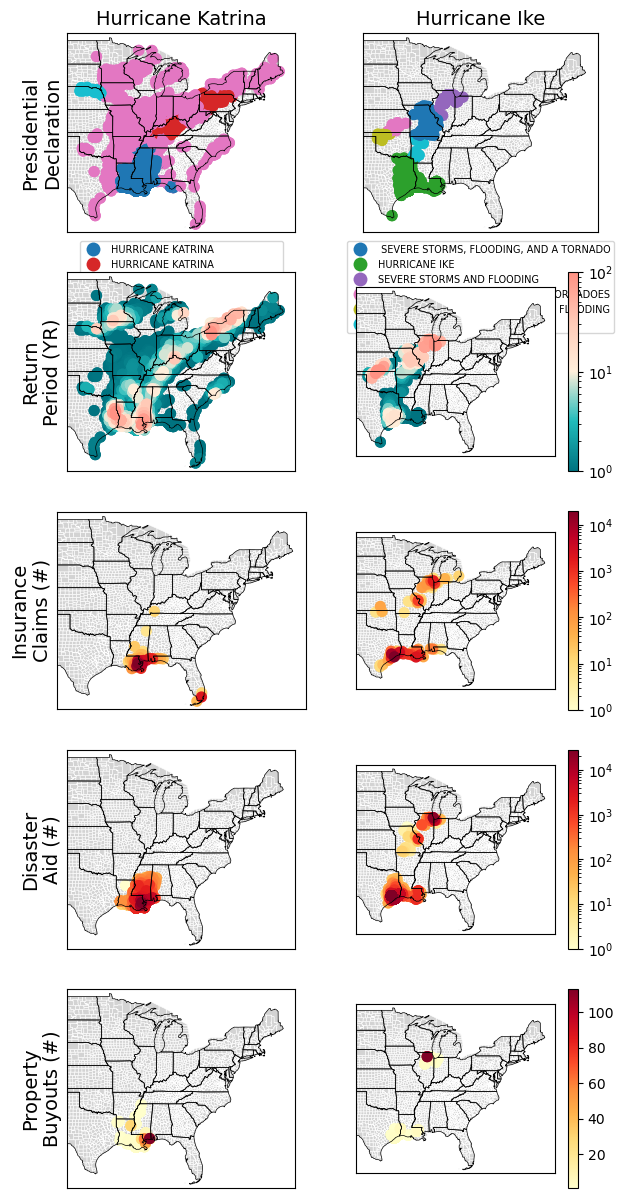

In [32]:
# Create the figure and subplots (5 vertical subplots)
fig, axes = plt.subplots(5, 2, figsize=(7.08, 15))

# First subplot: original plot
ax1 = axes[0,0]
gdf_counties.plot(ax=ax1, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax1, color='black', linewidth=0.5)
scatter = gdf_points.plot(
    ax=ax1,
    column='declarationTitle',
    cmap='tab10',
    markersize=50,
    legend=True,
    legend_kwds={'bbox_to_anchor': (0.5, -0.02), 'loc': 'upper center', 'ncol': 1, 'fontsize':7}

)

# Set extent and labels for the first subplot
ax1.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax1.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax1.set_title('Hurricane Katrina', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Presidential\nDeclaration', fontsize=14)
ax1.axis('on')  # Turn on the axis
ax1.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Second subplot: points colored by 'returnPeriod_MSWEP_1d' with log colormap
ax2 = axes[1,0]
gdf_counties.plot(ax=ax2, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax2, color='black', linewidth=0.5)
gdf_points = gdf_points.sort_values(by=return_per, ascending=True)
gdf_points.plot(
    ax=ax2,
    column=return_per,
    cmap=cmap_left,
    markersize=50,
    legend=False,
    norm=norm
)

# Set extent and labels for the second subplot
ax2.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax2.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax2.set_title('Return Period (YR)', fontsize=16)
ax2.set_xlabel('')
ax2.set_ylabel('Return\nPeriod (YR)', fontsize=14)
ax2.axis('on')  # Turn on the axis
ax2.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Third subplot: points colored by 'claim_counts' with yellow-red colormap
ax3 = axes[2,0]
gdf_counties.plot(ax=ax3, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax3, color='black', linewidth=0.5)
gdf_claims = gdf_claims.sort_values(by='claim_counts', ascending=True)
gdf_claims.plot(
    ax=ax3,
    column='claim_counts',
    cmap=cmap_approved,
    markersize=50,
    legend=False,
    norm=log_norm2
)

# Set extent and labels for the third subplot
ax3.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax3.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax3.set_title('Insurance Claims', fontsize=16)
ax3.set_xlabel('')
ax3.set_ylabel('Insurance\nClaims (#)', fontsize=14)
ax3.axis('on')  # Turn on the axis
ax3.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Fourth subplot: points colored by 'approvedForFemaAssistance' with yellow-red colormap
ax4 = axes[3,0]
gdf_counties.plot(ax=ax4, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax4, color='black', linewidth=0.5)
gdf_points = gdf_points.sort_values(by='approvedForFemaAssistance', ascending=True)
gdf_points.plot(
    ax=ax4,
    column='approvedForFemaAssistance',
    cmap=cmap_approved,
    markersize=50,
    legend=False,
    norm=log_norm
)

# Set extent and labels for the fourth subplot
ax4.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax4.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax4.set_title('Disaster Aid', fontsize=16)
ax4.set_xlabel('')
ax4.set_ylabel('Disaster\nAid (#)', fontsize=14)
ax4.axis('on')  # Turn on the axis
ax4.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Fifth subplot: points colored by 'numberOfProperties' with yellow-red colormap
ax5 = axes[4,0]
gdf_counties.plot(ax=ax5, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax5, color='black', linewidth=0.5)
gdf_points = gdf_points.sort_values(by='numberOfProperties', ascending=True)
gdf_points.plot(
    ax=ax5,
    column='numberOfProperties',
    cmap=cmap_approved,
    markersize=50,
    legend=False
)

# Set extent and labels for the fifth subplot
ax5.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax5.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax5.set_title('Property Buyouts', fontsize=16)
ax5.set_xlabel('')
ax5.set_ylabel('Property\nBuyouts (#)', fontsize=14)
ax5.axis('on')  # Turn on the axis
ax5.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# First subplot: original plot
ax6 = axes[0,1]
gdf_counties.plot(ax=ax6, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax6, color='black', linewidth=0.5)
scatter = gdf_points2.plot(
    ax=ax6,
    column='declarationTitle',
    cmap='tab10',
    markersize=50,
    legend=True,
    legend_kwds={'bbox_to_anchor': (0.5, -0.02), 'loc': 'upper center', 'ncol': 1, 'fontsize':7}
)

# Set extent and labels for the first subplot
ax6.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax6.set_ylim(southern_us_extent[2], southern_us_extent[3])
ax6.set_title('Hurricane Ike', fontsize=14)
#ax6.set_xlabel('Longitude', fontsize=12)
#ax6.set_ylabel('Latitude', fontsize=12)
ax6.axis('on')  # Turn on the axis
ax6.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)
#ax6.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=2, fontsize=12)

# Second subplot: points colored by 'returnPeriod_MSWEP_1d' with log colormap
ax7 = axes[1,1]
gdf_counties.plot(ax=ax7, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax7, color='black', linewidth=0.5)
gdf_points2 = gdf_points2.sort_values(by=return_per, ascending=True)
gdf_points2.plot(
    ax=ax7,
    column=return_per,
    cmap=cmap_left,
    markersize=50,
    legend=True,
    norm=norm
)

# Set extent and labels for the second subplot
ax7.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax7.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax7.set_title('Return Period (YR)', fontsize=16)
#ax7.set_xlabel('Longitude', fontsize=12)
#ax7.set_ylabel('Latitude', fontsize=12)
ax7.axis('on')  # Turn on the axis
ax7.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Third subplot: points colored by 'claim_counts' with yellow-red colormap
ax8 = axes[2,1]
gdf_counties.plot(ax=ax8, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax8, color='black', linewidth=0.5)
gdf_claims2 = gdf_claims2.sort_values(by='claim_counts', ascending=True)
gdf_claims2.plot(
    ax=ax8,
    column='claim_counts',
    cmap=cmap_approved,
    markersize=50,
    legend=True,
    norm=log_norm2_2
)

# Set extent and labels for the third subplot
ax8.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax8.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax8.set_title('Insurance Claims', fontsize=16)
#ax8.set_xlabel('Longitude', fontsize=12)
#ax8.set_ylabel('Latitude', fontsize=12)
ax8.axis('on')  # Turn on the axis
ax8.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Fourth subplot: points colored by 'approvedForFemaAssistance' with yellow-red colormap
ax9 = axes[3,1]
gdf_counties.plot(ax=ax9, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax9, color='black', linewidth=0.5)
gdf_points2 = gdf_points2.sort_values(by='approvedForFemaAssistance', ascending=True)
gdf_points2.plot(
    ax=ax9,
    column='approvedForFemaAssistance',
    cmap=cmap_approved,
    markersize=50,
    legend=True,
    norm=log_norm_2
)

# Set extent and labels for the fourth subplot
ax9.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax9.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax9.set_title('Disaster Aid', fontsize=16)
#ax9.set_xlabel('Longitude', fontsize=12)
#ax9.set_ylabel('Latitude', fontsize=12)
ax9.axis('on')  # Turn on the axis
ax9.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Fifth subplot: points colored by 'numberOfProperties' with yellow-red colormap
ax10 = axes[4,1]
gdf_counties.plot(ax=ax10, color='lightgrey', edgecolor='white', linewidth=0.4)
gdf_states.boundary.plot(ax=ax10, color='black', linewidth=0.5)
gdf_points2 = gdf_points2.sort_values(by='numberOfProperties', ascending=True)
gdf_points2.plot(
    ax=ax10,
    column='numberOfProperties',
    cmap=cmap_approved,
    markersize=50,
    legend=True
)

# Set extent and labels for the fifth subplot
ax10.set_xlim(southern_us_extent[0], southern_us_extent[1])
ax10.set_ylim(southern_us_extent[2], southern_us_extent[3])
#ax10.set_title('Property Buyouts', fontsize=16)
#ax10.set_xlabel('Longitude', fontsize=12)
#ax10.set_ylabel('Latitude', fontsize=12)
ax10.axis('on')  # Turn on the axis
ax10.tick_params(axis='both', which='both', length=0, labelleft=False, labelbottom=False)

# Show the plot
plt.show()